## Analyzing Spherical Photon Orbits of Naked Singularities

## METHODS & IMPORTED PACKAGES

Importing AutoDiff packages for geodesic calculation:

In [1]:
! pip3 install -U -q jaxlib jax
! pip3 install git+https://github.com/adxsrc/xaj.git
! pip3 install git+https://github.com/adxsrc/fadge.git
! pip3 install git+https://github.com/adxsrc/pray.git

     |████████████████████████████████| 71.3 MB 71 kB/s 
     |████████████████████████████████| 990 kB 50.9 MB/s 
     |████████████████████████████████| 38.1 MB 1.2 MB/s 
     |████████████████████████████████| 98 kB 6.6 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/adxsrc/xaj.git to /tmp/pip-req-build-ifspr2ju
  Running command git clone -q https://github.com/adxsrc/xaj.git /tmp/pip-req-build-ifspr2ju
  Created wheel for xaj: filename=xaj-0.1.6-py3-none-any.whl size=23838 sha256=8e8c6f913695e859777b06b3bb915bedb3778e2314d52cd0f034eca7560a1c07
  Stored in directory: /tmp/pip-ephem-wheel-cache-kgnz__ps/wheels/24/1c/b1/2240eb4d

In [4]:
%load_ext autoreload
%autoreload 2

from jax.config import config
config.update("jax_enable_x64", True)

from pray      import PRay
from fadge.viz import KSHorizons as Horizons
from fadge.metric import KerrSchild as CartesianKS
from fadge.metric import Minkowski
from jax       import numpy as np

from matplotlib import pyplot as plt
from itertools  import product
from scipy.signal import argrelextrema

import jax
import h5py

from os   import mkdir, path
from glob import glob

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Method to calculate deflection angle:

In [12]:
alpha = 16*((np.arange(1024)+0.5)/1024-0.5)

def da(f):
    k  = f[:,1]
    ki = k[-1,1:]
    kf = k[ 0,1:]
    
    fi = np.einsum('ijk,ijk->jk', kf, ki)
    ff = np.einsum('ijk,ijk->jk', kf, kf)
    ii = np.einsum('ijk,ijk->jk', ki, ki)
    
    return np.arccos(fi / np.sqrt(ff * ii))

def argmax(d):
    am = argrelextrema(d, np.greater)[0]
    am = np.array([a for a in am if max(d[a+1]-d[a], d[a]-d[a-1]) > 0.02])
    return am

def argmin(d):
    am = argrelextrema(d, np.less)[0]
    am = np.array([a for a in am if min(d[a+1]-d[a], d[a]-d[a-1]) <-0.02])
    return am

def unfold(d):
#     aM = argmax(deflection)
#     aR = np.where(deflection[aM[:len(aM)//2]] > 3)[0]
#     if len(aR) >= 2:
#         deflection[aM[aR[0]]+1:aM[aR[-1]]] = 2*np.pi - deflection[aM[aR[0]]+1:aM[aR[-1]]]

#     aM = argmax(deflection)
#     aR = np.where(deflection[aM[:len(aM)//2]] > 6)[0]
#     if len(aR) >= 2:
#         deflection[aM[aR[0]]+1:aM[aR[-1]]] = 4*np.pi - deflection[aM[aR[0]]+1:aM[aR[-1]]]

#     aM = argmax(deflection)
#     aR = np.where(deflection[aM[:len(aM)//2]] > 9)[0]
#     if len(aR) >= 2:
#         deflection[aM[aR[0]]+1:aM[aR[-1]]] = 6*np.pi - deflection[aM[aR[0]]+1:aM[aR[-1]]]

#     aM = argmax(deflection)
#     aR = np.where(deflection[aM[:len(aM)//2]] > 12)[0]
#     if len(aR) >= 2:
#         deflection[aM[aR[0]]+1:aM[aR[-1]]] = 8*np.pi - deflection[aM[aR[0]]+1:aM[aR[-1]]]

#     am = argmin(deflection)    
#     try:
#         deflection[am[0]:am[-1]] *= -1
#     except:
#         pass
    return d

def deflection_angle(a, i):
    
    file = f'/content/drive/My Drive/Colab Notebooks/Naked Singularities Data/image_a{a:.2f}_i{i:g}.h5'

    try:
        with h5py.File(file) as h:
            C = h['f'][:]
        t = C[0,0,0]
        x = C[0,0,1]
        y = C[0,0,2]
        z = C[0,0,3]
        r = np.sqrt(x*x + y*y + z*z)
        print(np.nanmin(t), np.nanmax(t))
        print(np.nanmin(r), np.nanmax(r))
        C = unfold(da(C))
    except:
        C = np.zeros((128,128))

    deflection = C / np.pi * 180

    return deflection

Analytical calculation of the black hole shadow:

In [7]:
from cmath import cos, acos
from math  import sqrt

def _cos23acos(x):
    y = cos(2 * acos(x) / 3)
    if y.imag != 0:
        #print(f'WARNING: cos23acos({x}) == ${y}')
        return np.nan
    else:
        return y.real

def cos23acos(X):
    try:
        return np.array([_cos23acos(x) for x in np.array(X)])
    except TypeError:
        return _cos23acos(X)

def PHI(a, r):
    if a == 0 and r == 3:
        return 0 # 2 * a + (9/2) * (r-3) / a
    elif a == 1:
        return - (r * r - 2 * r - 1)
    else:
        return - (r * r * r - 3 * r * r + a * a * r + a * a) / (a * (r - 1))

def Q(a, r):
    if a == 0 and r == 3:
        return 27 # (r**3 / (r-1)**2) * (4 - r * (r-3)**2 / a**2)
    if a == 1:
        return - r*r*r * (r - 4)
    else:
        return - (r*r*r * (r*r*r - 6*r*r + 9*r - 4*a*a)) / (a*a * (r - 1) * (r - 1))

def shadow(aspin, inc):
    if abs(aspin) <= 1:
        r1 = rph1(aspin)
    else:
        r1 = 1
    rs = np.linspace(r1, rph2(aspin), num=100)

    a = np.array([PHI(aspin, r) for r in rs]) / np.sin(inc)
    b = np.array([np.sqrt(Q(aspin, r) + (aspin * np.cos(inc))**2 - (PHI(aspin, r) / np.tan(inc))**2) for r in rs])
    
    return (
        np.concatenate([-a, -a[::-1], -a[:1]]),
        -np.concatenate([ b, -b[::-1],  b[:1]]),
    )

Z1 = lambda a: 1 + np.cbrt(1 - a*a) * (np.cbrt(1 + a) + np.cbrt(1 - a))
Z2 = lambda a: np.sqrt(3 * a * a + Z1(a) * Z1(a))

reh1 = lambda a: 1 - np.sqrt(1 - a * a)
reh2 = lambda a: 1 + np.sqrt(1 - a * a)
rph1 = lambda a: 2 * (1 + cos23acos(-abs(a)))
rph2 = lambda a: 2 * (1 + cos23acos( abs(a)))
rmb1 = lambda a: 2 - abs(a) + 2 * np.sqrt(1 - abs(a))
rmb2 = lambda a: 2 + abs(a) + 2 * np.sqrt(1 + abs(a))
rms1 = lambda a: 3 + Z2(a) - np.sqrt((3 - Z1(a)) * (3 + Z1(a) + 2 * Z2(a)))
rms2 = lambda a: 3 + Z2(a) + np.sqrt((3 - Z1(a)) * (3 + Z1(a) + 2 * Z2(a)))

Method to plot deflection angle and the analytical photon ring:

In [6]:
def mkplot(a, i):
    
    file = f'/content/drive/My Drive/Colab Notebooks/Naked Singularities Data/image_a{a:.2f}_i{i:g}.h5'

    try:
        with h5py.File(file) as h:
            C = h['f'][:]
        t = C[0,0,0]
        x = C[0,0,1]
        y = C[0,0,2]
        z = C[0,0,3]
        r = np.sqrt(x*x + y*y + z*z)
        print(np.nanmin(t), np.nanmax(t))
        print(np.nanmin(r), np.nanmax(r))
        C = unfold(da(C))
    except:
        C = np.zeros((128,128))

    try:
        with h5py.File(file) as h:
            R = h['f'][:]
        R = unfold(da(R))
    except:
        R = np.zeros((128,128))
    
    fig, ax = plt.subplots(1,1,figsize=(18,12))
    deflection = np.vstack([C]) / np.pi * 180
    
    im = ax.imshow(
        deflection.T, origin='lower', extent=[-8,8,-8,8], 
        vmin=0, vmax=180,
        cmap='seismic',

        #cmap='RdBu_r'
    )
    ax.set_aspect('equal')
    ax.set_title(r'$a_\mathrm{spin}$'+f'={a:.02f}, '+r'$i$'+f'={i}'+r'$^\circ$')
    ax.set_xlabel(r'$\alpha$ [$M$]')
    ax.set_ylabel(r'$\beta$ [$M$]')
    plt.plot(*shadow(aspin = a, inc = i*np.pi/180), 'yellow', linewidth=7) 

    ax.set_xlim(-8,8)
    ax.set_ylim(-8,8)
    
    pos  = ax.get_position()
    cax  = fig.add_axes([pos.x1+0.01, pos.y0, 0.02, pos.y1-pos.y0])
    cbar = fig.colorbar(im, cax=cax)
    #cbar.ax.tick_params(labelsize=16)
    cbar.set_label(label=r'Deflection Angle [$^\circ$]')

#    plt.colorbar(im, cax=cax)
    
    return fig

Crude method to find winding number:

In [8]:
def winding(index):
  x = f[:,0,1,ii_outer[index], jj_outer[index]]
  y = f[:,0,1,ii_outer[index], jj_outer[index]]
  theta_initial = theta(x[-1], y[-1])
  wn = 0
  for k in range(1, np.size(x)):
    theta_now = theta(x[k], y[k])
    theta_before = theta(x[k-1], y[k-1])

    if theta_before < theta_initial and theta_now > theta_initial:
      wn -= 1
    elif theta_before > theta_initial and theta_now < theta_initial:
      wn += 1

  return wn

2D plotting of geodesics (xy, xz and yz planes):

In [9]:
def plot(iarr, jarr, size, a, f):
  from fadge.viz import KSHorizons as Horizons
  horizons = Horizons(a)

  fig, axes = plt.subplots(2,2, figsize=(12,12), sharex=True, sharey=True)
  fig.tight_layout()
  for ax in [a for ax in axes for a in ax]:
      ax.set_xlim(-size,size)
      ax.set_ylim(-size,size)
      ax.set_aspect('equal')

  ax = axes[0][0]
  horizons(ax, color='k')
  ax.set_xlabel('x')
  ax.set_ylabel('z')

  ax = axes[0][1]
  horizons(ax, color='k')
  ax.set_xlabel('y')
  ax.set_ylabel('z')

  ax = axes[1][0]
  horizons(ax, color='k', faceon=True)
  ax.set_xlabel('x')
  ax.set_ylabel('y')

  for k in range(np.size(iarr)):
    x = f[:, 0, 1, iarr[k], jarr[k]]
    y = f[:, 0, 2, iarr[k], jarr[k]]
    z = f[:, 0, 3, iarr[k], jarr[k]]

    axes[0][0].plot(x, z, '-o', color=f'C{k//4}')
    axes[0][1].plot(y, z, '-o', color=f'C{k//4}')
    axes[1][0].plot(x, y, '-o', color=f'C{k//4}')

def plot_single(i, j, initial, final, size, a, f):
  from fadge.viz import KSHorizons as Horizons
  horizons = Horizons(a)

  fig, axes = plt.subplots(2,2, figsize=(12,12), sharex=True, sharey=True)
  fig.tight_layout()
  for ax in [a for ax in axes for a in ax]:
      ax.set_xlim(-size,size)
      ax.set_ylim(-size,size)
      ax.set_aspect('equal')

  ax = axes[0][0]
  horizons(ax, color='k')
  ax.set_xlabel('x')
  ax.set_ylabel('z')

  ax = axes[0][1]
  horizons(ax, color='k')
  ax.set_xlabel('y')
  ax.set_ylabel('z')

  ax = axes[1][0]
  horizons(ax, color='k', faceon=True)
  ax.set_xlabel('x')
  ax.set_ylabel('y')

  x = f[initial:final, 0, 1, i, j]
  y = f[initial:final, 0, 2, i, j]
  z = f[initial:final, 0, 3, i, j]

  axes[0][0].plot(x, z, '-o')
  axes[0][1].plot(y, z, '-o')
  axes[1][0].plot(x, y, '-o')

## Example: a = 1.19, inc = 15o

Deflection angle plot of a naked singularity with (normalized) spin 1.19 and inclination angle 15o:

-21971.156122117874 -21971.156122117874
11839.197980581495 11936.704996673701


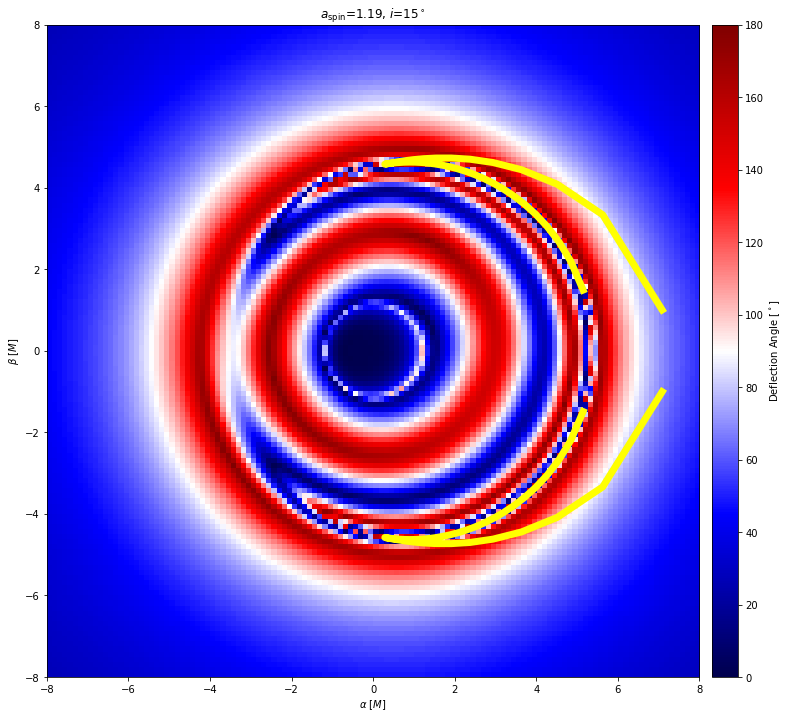

In [10]:
fig = mkplot(1.19, 15)

Surveying pixels of the above plot where there is a high deflection angle (> 158o). (ii, jj) gives 2 arrays of the (row, column) values of those pixels

In [13]:
a = 1.19
i = 15
deflection = deflection_angle(a, i)
(ii, jj) = np.where(deflection >= 158)

-21971.156122117874 -21971.156122117874
11839.197980581495 11936.704996673701


We can see that there are 3 distinct layers of high deflection angles:

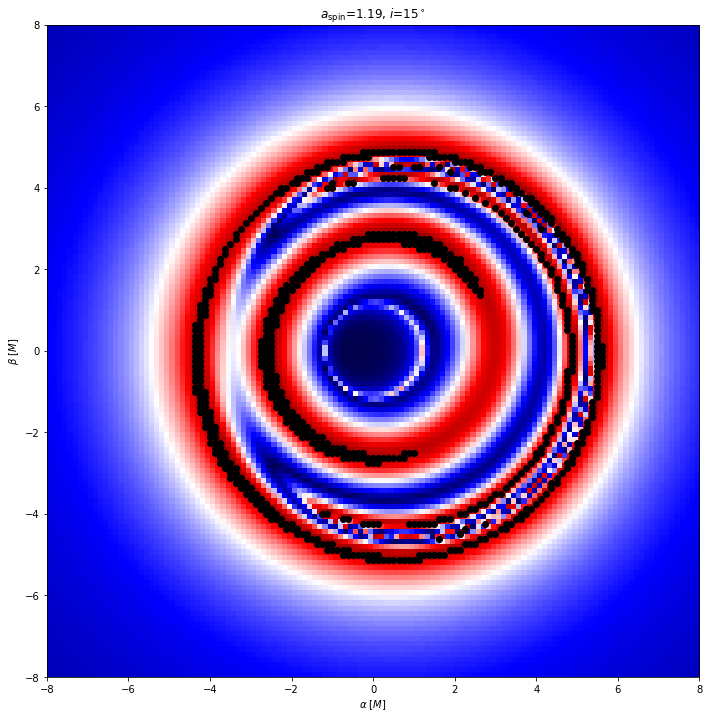

In [14]:
fig, ax = plt.subplots(1,1,figsize=(18,12))
im = ax.imshow(
    deflection.T, origin='lower', extent=[-8,8,-8,8], 
    vmin=0, vmax=180,
    cmap='seismic',

    #cmap='RdBu_r'
)
ax.set_aspect('equal')
ax.set_title(r'$a_\mathrm{spin}$'+f'={a:.02f}, '+r'$i$'+f'={i}'+r'$^\circ$')
ax.set_xlabel(r'$\alpha$ [$M$]')
ax.set_ylabel(r'$\beta$ [$M$]')
plt.scatter(ii/8 - 8, jj/8 - 8, color = "black") 

I propose a method to extract only the outermost layer of the high deflection angle pixels, the candidate regions of spherical photon orbits. Firstly, convert the (row, column) values of the pixels to polar coordinates (radius, angle). Then, I dissect the circular polar coordinate plane into 200 slices, and for each slice, I extract the high deflection angle pixel with the highest radius.

In [15]:
rr = np.array([])
angle = np.array([])

for k in range(np.size(ii)):
  x = jj[k]-64
  y = ii[k]-64

  theta = np.arctan(y/x)
  if x < 0:
    theta += np.pi
  r = np.sqrt(x**2 + y**2)

  rr = np.append(rr, r)
  angle = np.append(angle, theta)

spacing = 2*np.pi/200
outer = np.array([])
for k in np.linspace(-np.pi/2, np.pi * 3/2, 200):
  index = np.where((angle >= k) & (angle < (k + spacing)))
  rr_index = rr[index]
  if len(rr_index) != 0:
    outer_index = index[0][np.argmax(rr_index)]
    outer = np.append(outer, outer_index)

This method seems to work fine, though there are 2 leftovers from the inner layer:

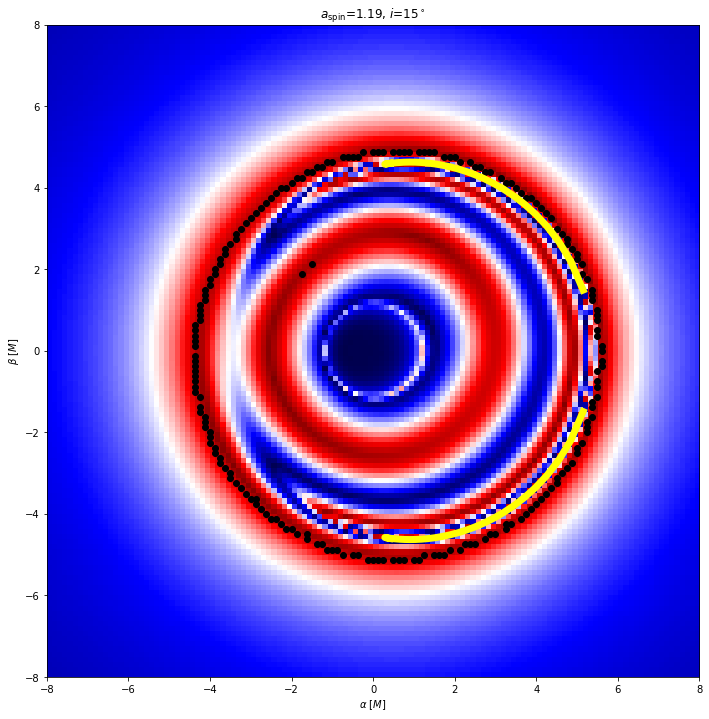

In [52]:
ii_outer = ii[outer.astype(int)]
jj_outer = jj[outer.astype(int)]
fig, ax = plt.subplots(1,1,figsize=(18,12))
im = ax.imshow(
    deflection.T, origin='lower', extent=[-8,8,-8,8], 
    vmin=0, vmax=180,
    cmap='seismic',

    #cmap='RdBu_r'
)
ax.set_aspect('equal')
ax.set_title(r'$a_\mathrm{spin}$'+f'={a:.02f}, '+r'$i$'+f'={i}'+r'$^\circ$')
ax.set_xlabel(r'$\alpha$ [$M$]')
ax.set_ylabel(r'$\beta$ [$M$]')
plt.scatter(ii_outer/8 - 8, jj_outer/8 - 8, color = "black") 
plt.plot(ishadow[20:180], jshadow[20:180],'yellow', linewidth=7) 

However, there is a problem: the numerical "photon ring" (black dots) doesn't fit with the analytical calculation (yellow arcs), which contradictingly indicates a region of low deflection angles based on the numerical simulations. 

In [19]:
file = f'/content/drive/My Drive/Colab Notebooks/Naked Singularities Data/image_a{a:.2f}_i{i:g}.h5'

with h5py.File(file) as h:
    f = h['f'][:]

A quick survey through the outer black dot regions of high deflection angles show that these trajectories barely revolve about the naked singularity. By observations, these trajectories don't seem to have a high winding number in the x-y projection.

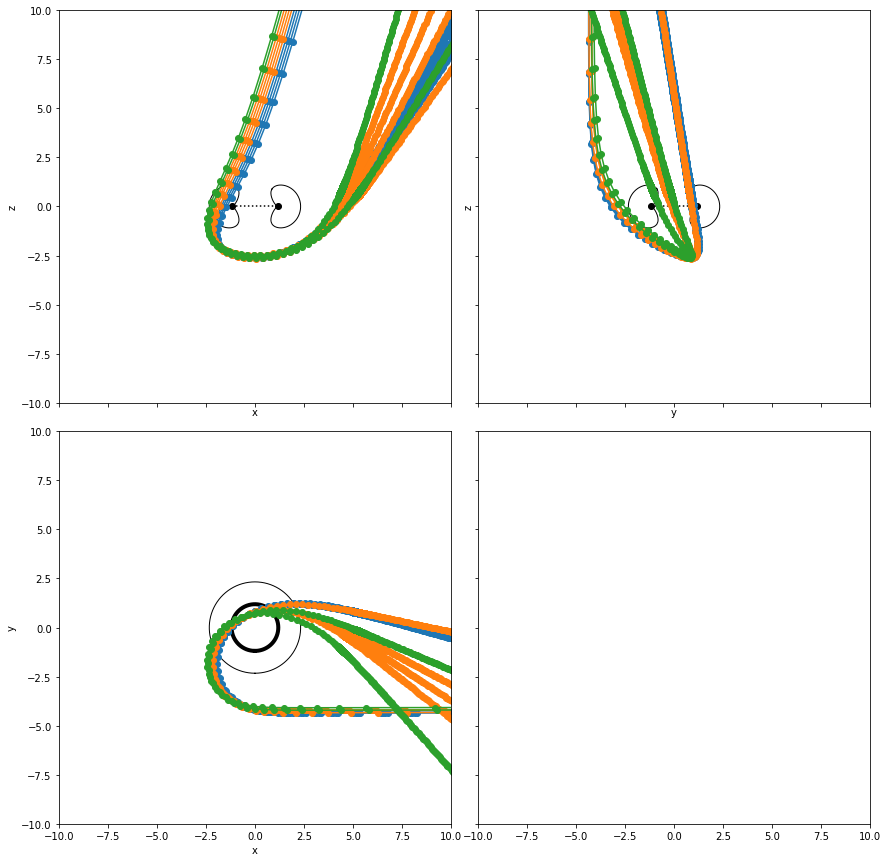

In [21]:
plot(ii_outer[0:10], jj_outer[0:10], 10, 1.19, f)

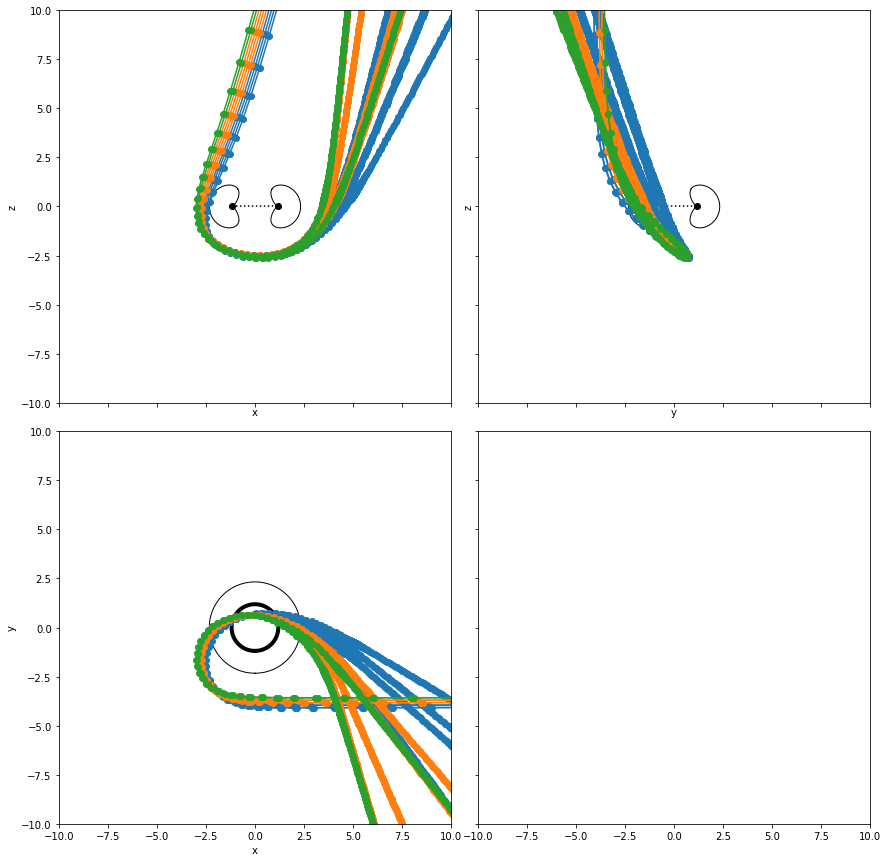

In [22]:
plot(ii_outer[10:20], jj_outer[10:20], 10, 1.19, f)

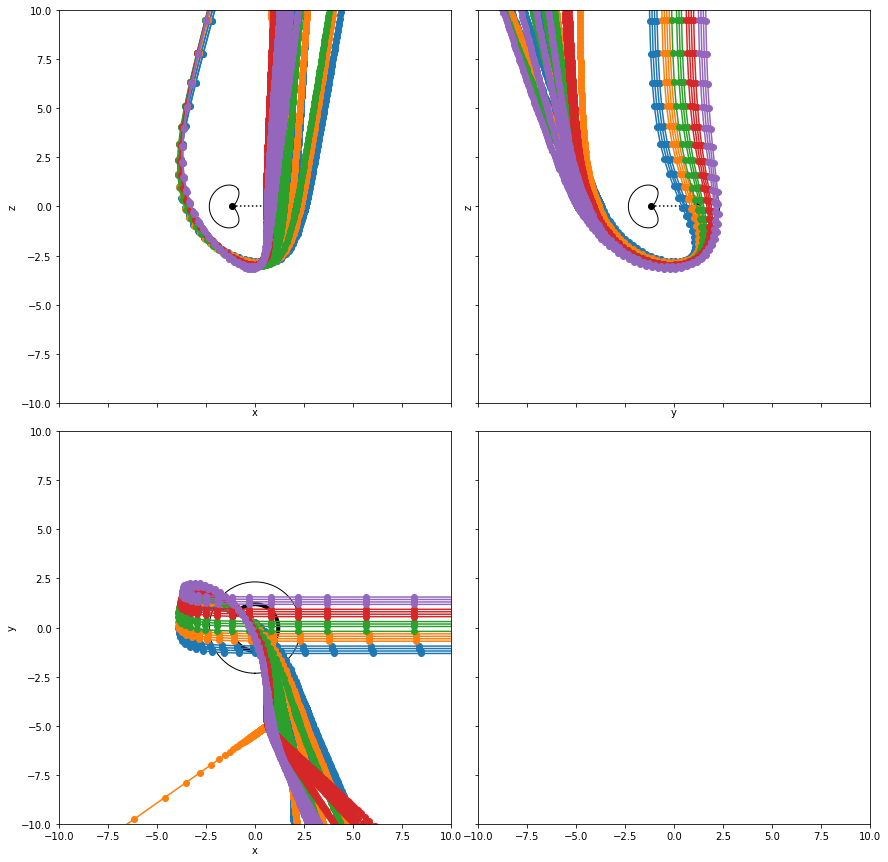

In [29]:
plot(ii_outer[40:60], jj_outer[40:60], 10, 1.19, f)

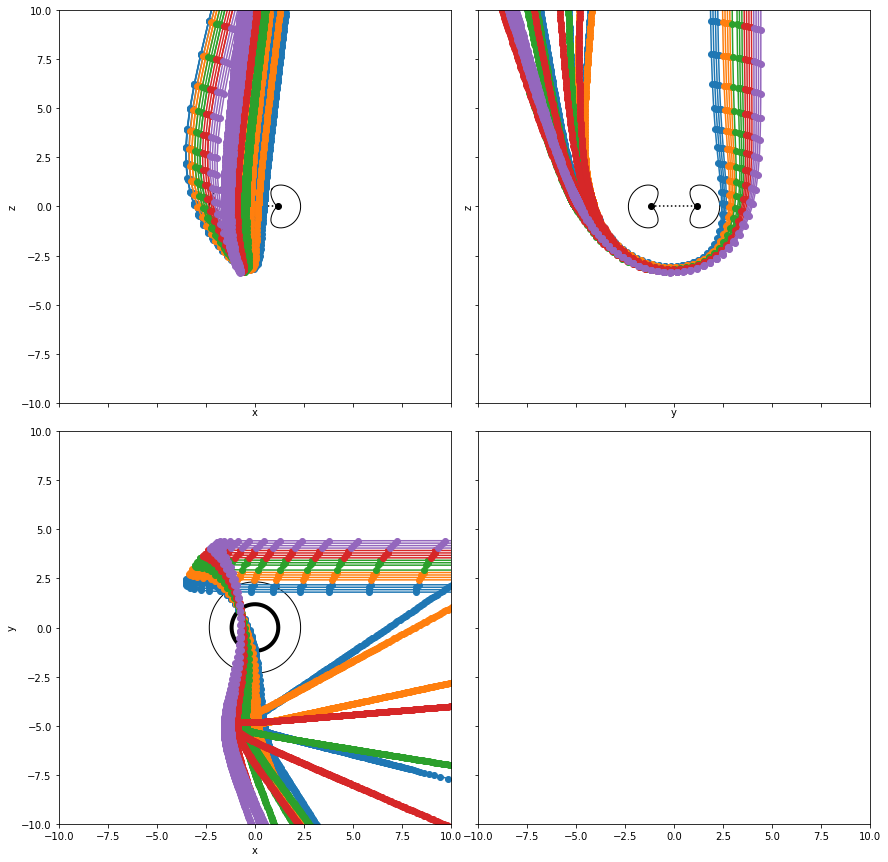

In [30]:
plot(ii_outer[60:80], jj_outer[60:80], 10, 1.19, f)

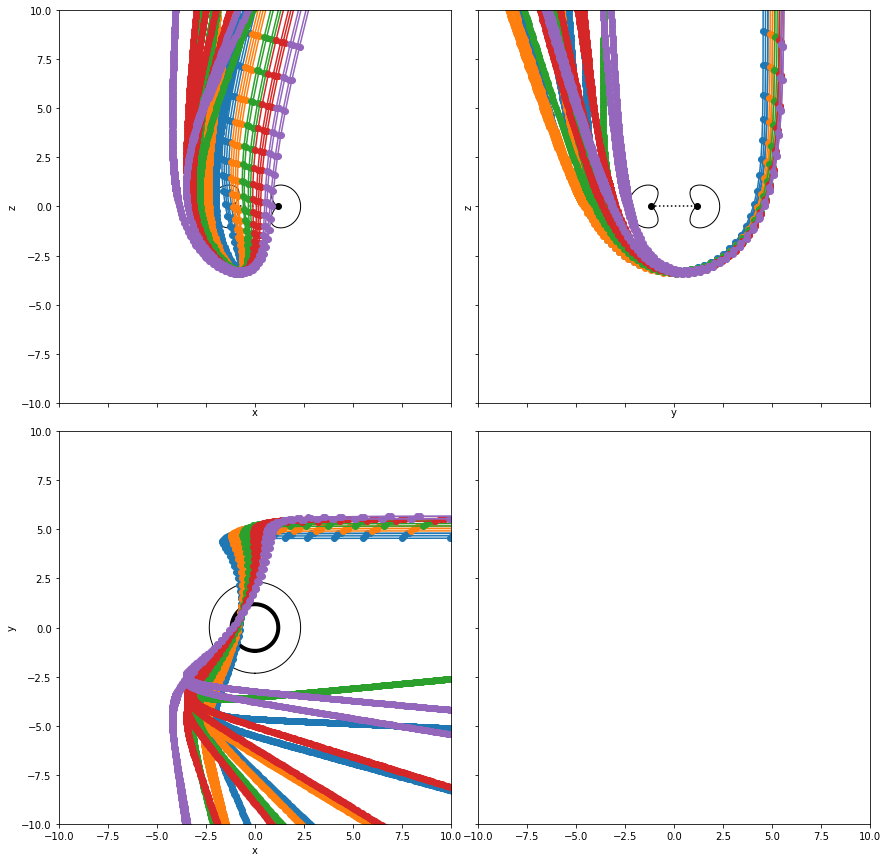

In [31]:
plot(ii_outer[80:100], jj_outer[80:100], 10, 1.19, f)

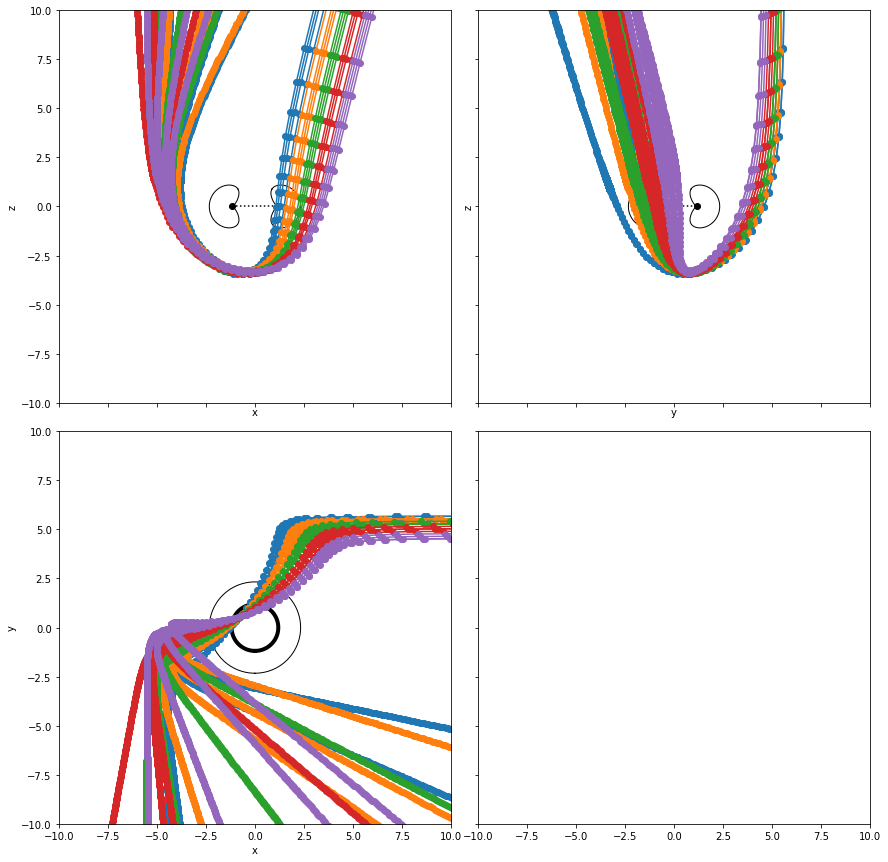

In [32]:
plot(ii_outer[100:120], jj_outer[100:120], 10, 1.19, f)

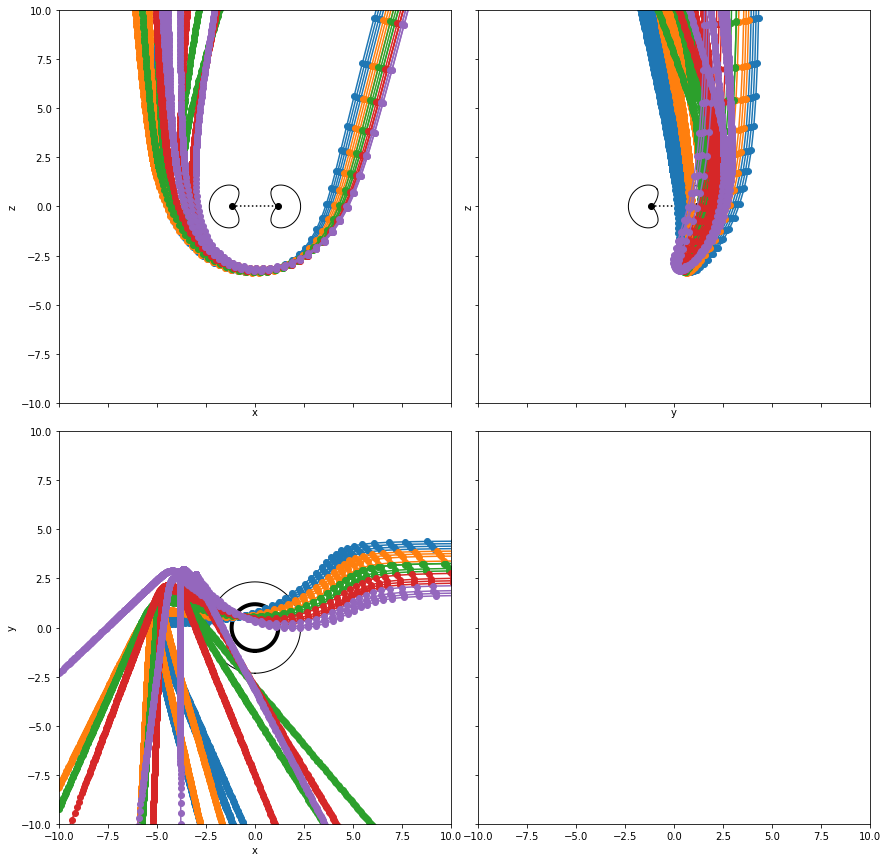

In [33]:
plot(ii_outer[120:140], jj_outer[120:140], 10, 1.19, f)

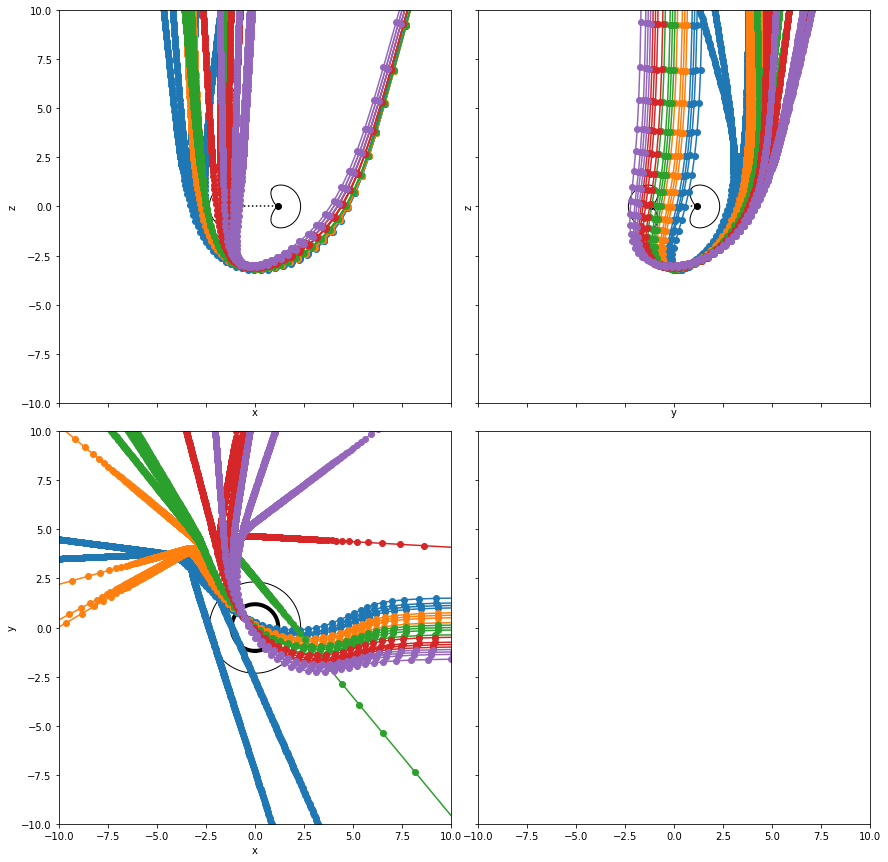

In [34]:
plot(ii_outer[140:160], jj_outer[140:160], 10, 1.19, f)

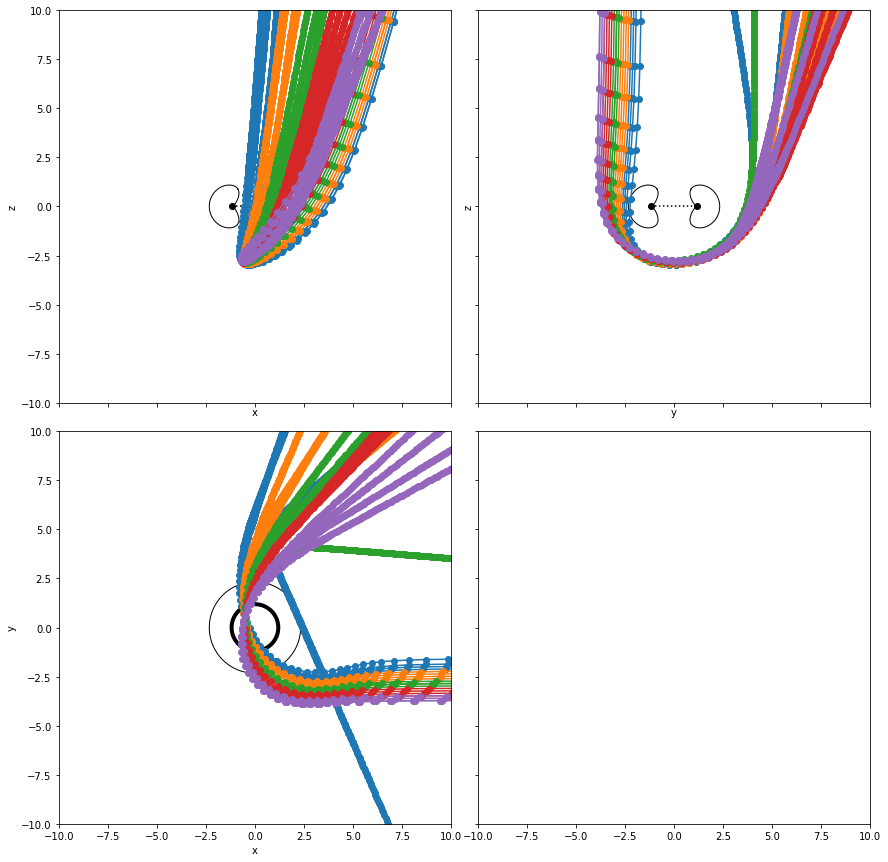

In [35]:
plot(ii_outer[160:180], jj_outer[160:180], 10, 1.19, f)

How about the pixels corresponding to the analytical calculation of the "photon ring"? For the following, I will only consider the crescent yellow part that fits the usual notion of a "photon ring" and ignore the green part that is most likely just a mathematical artifact from calculations of a naked singularity.

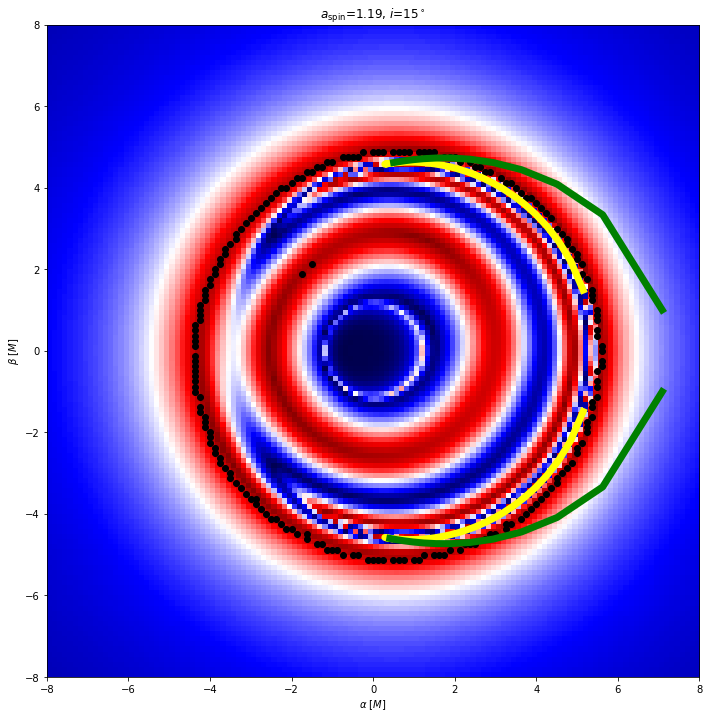

In [58]:
ii_outer = ii[outer.astype(int)]
jj_outer = jj[outer.astype(int)]
fig, ax = plt.subplots(1,1,figsize=(18,12))
im = ax.imshow(
    deflection.T, origin='lower', extent=[-8,8,-8,8], 
    vmin=0, vmax=180,
    cmap='seismic',

    #cmap='RdBu_r'
)
ax.set_aspect('equal')
ax.set_title(r'$a_\mathrm{spin}$'+f'={a:.02f}, '+r'$i$'+f'={i}'+r'$^\circ$')
ax.set_xlabel(r'$\alpha$ [$M$]')
ax.set_ylabel(r'$\beta$ [$M$]')
plt.scatter(ii_outer/8 - 8, jj_outer/8 - 8, color = "black") 
plt.plot(ishadow[20:180], jshadow[20:180],'yellow', linewidth=7) 
plt.plot(ishadow[:21], jshadow[:21],'green', linewidth=7) 
plt.plot(ishadow[180:], jshadow[180:],'green', linewidth=7) 

Here is a quick survey of the pixels corresponding to yellow arc. A common feature is that there are very sharp turns and bizarre loops when the trajectories start to orbit about the naked singularity. These strange behaviors appear to happen near the ergosphere and cause the photons to go through instead of returning to the observer as expected for a spherical photon orbit. 

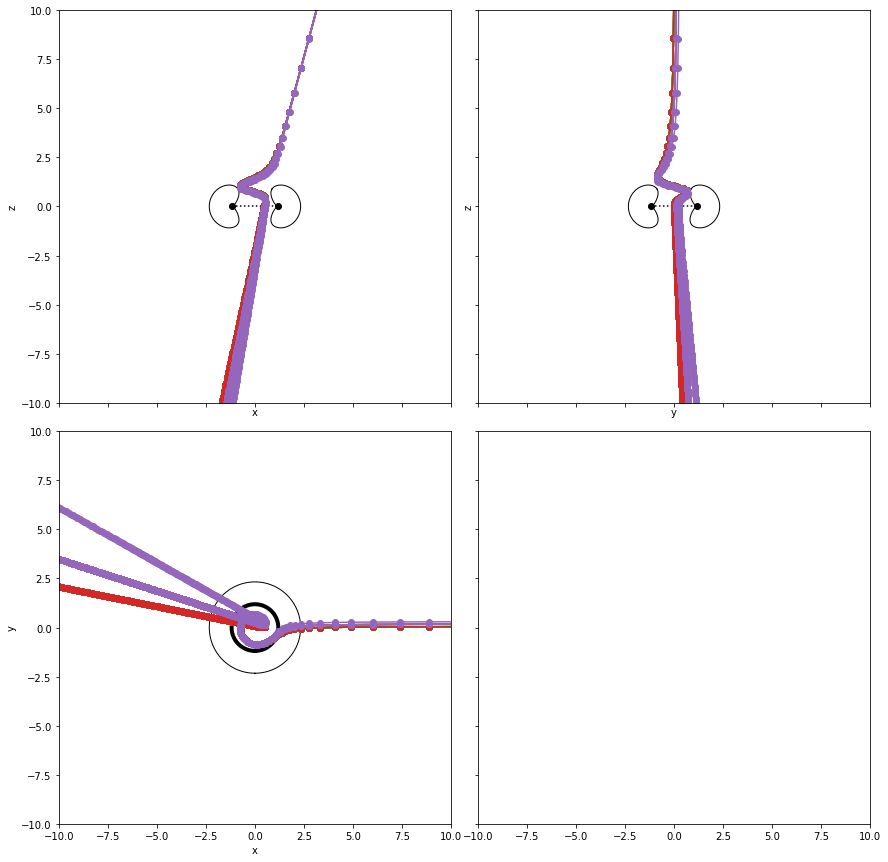

In [54]:
ishadow, jshadow = shadow(a, i*np.pi/180)
plot(ishadow.astype("int")[20:40] + 8 * 8, jshadow.astype("int")[20:40] + 8 * 8, 10, 1.19, f)

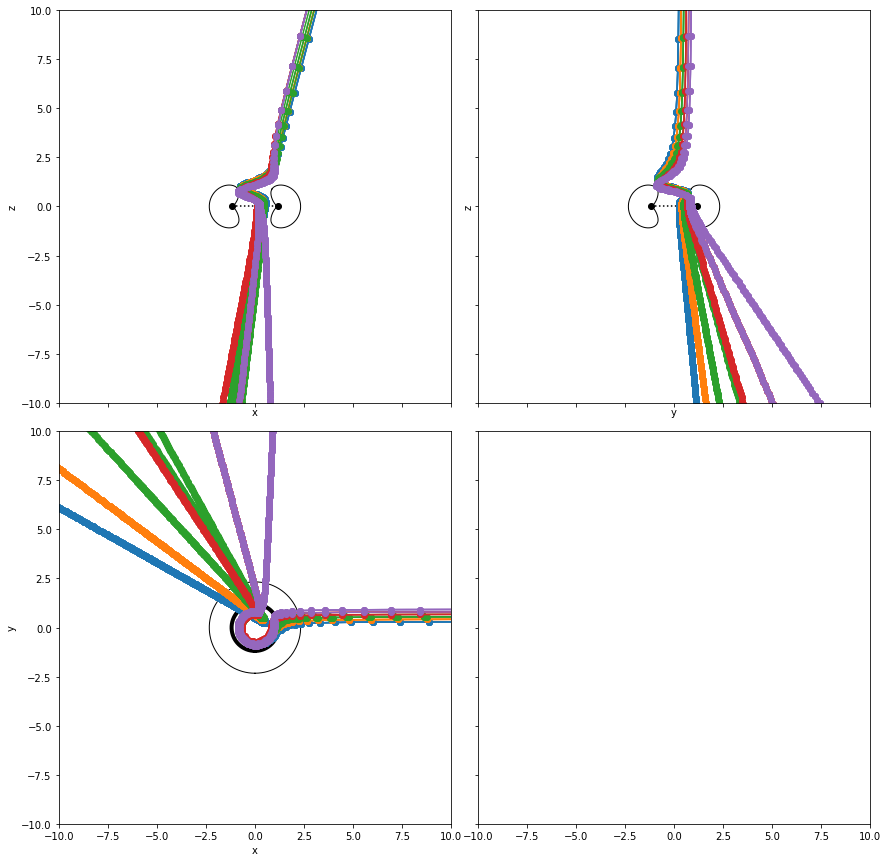

In [53]:
plot(ishadow.astype("int")[40:60] + 8 * 8, jshadow.astype("int")[40:60] + 8 * 8, 10, 1.19, f)

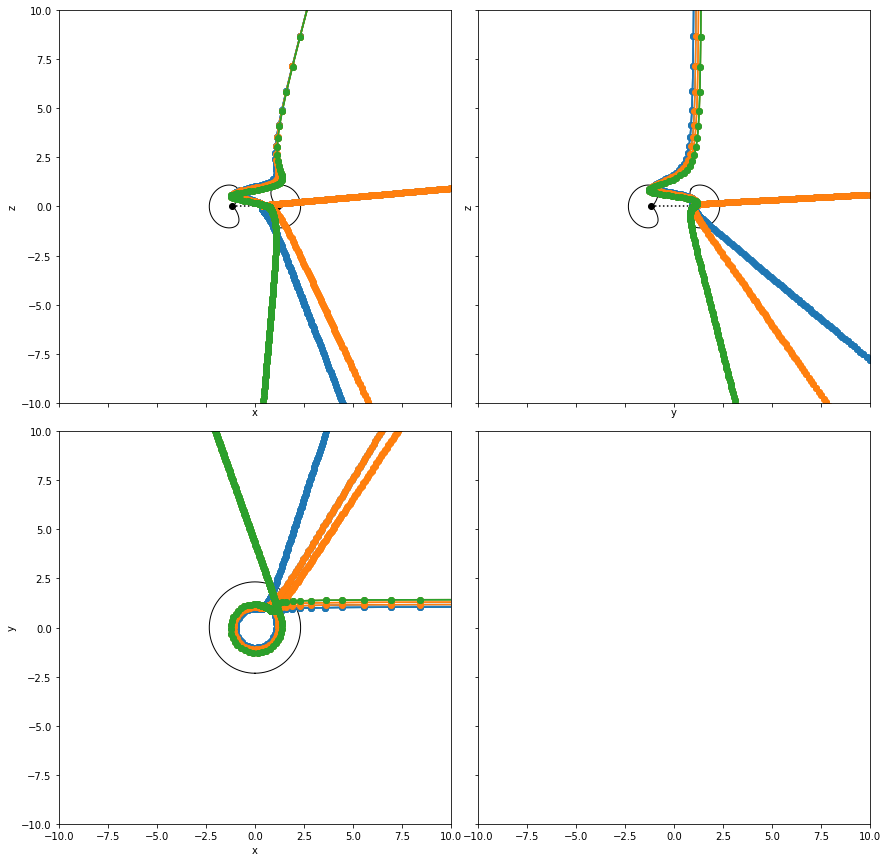

In [41]:
plot(ishadow.astype("int")[60:70] + 8 * 8, jshadow.astype("int")[60:70] + 8 * 8, 10, 1.19, f)

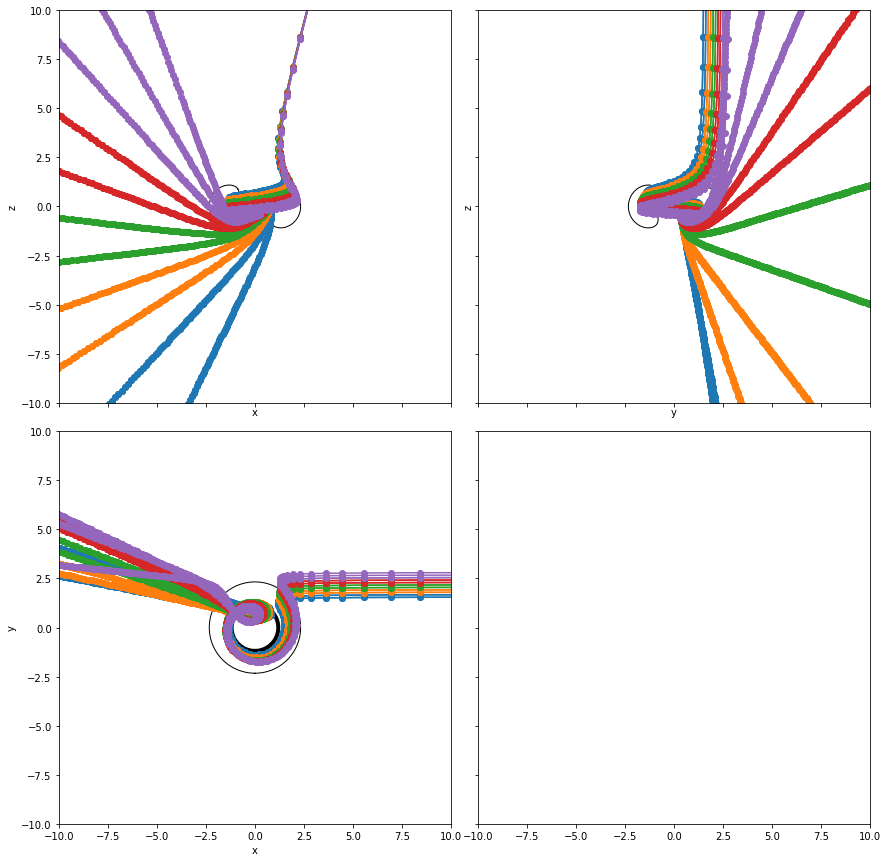

In [43]:
plot(ishadow.astype("int")[70:90] + 8 * 8, jshadow.astype("int")[70:90] + 8 * 8, 10, 1.19, f)

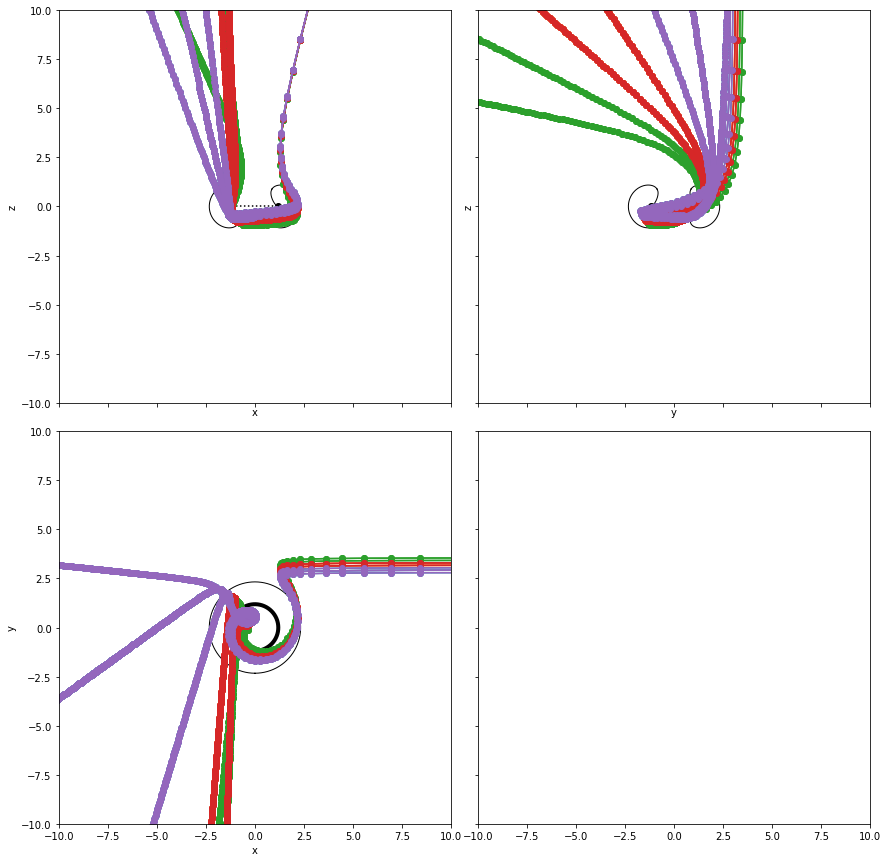

In [44]:
plot(ishadow.astype("int")[90:110] + 8 * 8, jshadow.astype("int")[90:110] + 8 * 8, 10, 1.19, f)

In [ ]:
plot(ishadow.astype("int")[70:90] + 8 * 8, jshadow.astype("int")[70:90] + 8 * 8, 10, 1.19, f)

In [45]:
ishadow[]

DeviceArray([        inf, 79.3501987 , 37.11541077, 23.05043064,
             16.03288341, 11.83829409,  9.05850435,  7.09001778,
              5.63108615,  4.51407157,  3.63839131,  2.94003816,
              2.37634066,  1.91775703,  1.543186  ,  1.23715329,
              0.98805321,  0.78701081,  0.62712336,  0.50294131,
              0.41010506,  0.34508538,  0.30499472,  0.28744774,
              0.29045662,  0.31235161,  0.35171985,  0.40735778,
              0.47823378,  0.56345854,  0.66226129,  0.77397074,
              0.8979995 ,  1.0338314 ,  1.18101097,  1.3391348 ,
              1.5078443 ,  1.68681967,  1.87577475,  2.07445274,
              2.2826225 ,  2.50007547,  2.72662294,  2.96209374,
              3.20633229,  3.45919682,  3.72055788,  3.99029706,
              4.26830581,  4.55448443,  4.8487412 ,  5.1509916 ,
              5.46115762,  5.7791671 ,  6.10495328,  6.43845421,
              6.77961239,  7.12837433,  7.48469027,  7.84851378,
              8.21980156,

I am not sure what causes these problems, if there is a lack of understanding in applying the analytical calculation to a > 1 or if there is an issue with the numerical algorithm. Here is a quick numerical check with k dot k, which is supposed to be 0 for null geodesics.

We use vmap from JAX to vectorize the Cartesian Kerr-Schild metrization of all position vectors along the trajectories. We can find values of k dot k along the diagonals of p^alpha dot vectorized metric dot transposed p^alpha. 

[-8.73112726e-05 -8.73112716e-05 -8.73112701e-05 ...  1.64360747e-11
  8.41871017e-12 -1.35447209e-14]


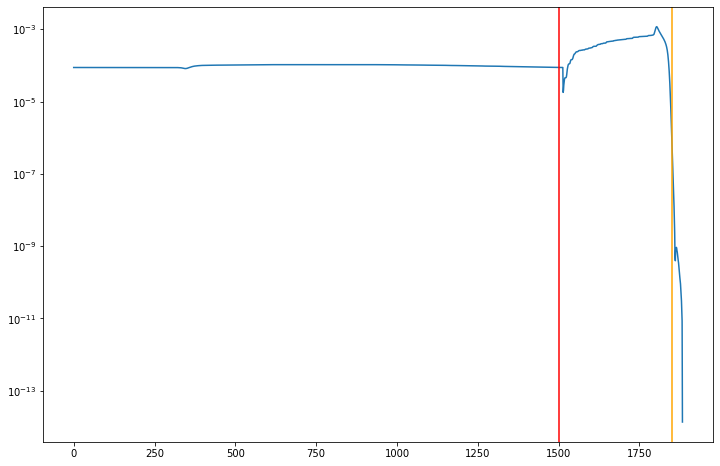

In [71]:
ishadow_ex = ishadow.astype("int")[15] + 8 * 8
jshadow_ex = jshadow.astype("int")[15] + 8 * 8

from fadge.metric import KerrSchild

xx = f[:,0,:,ishadow_ex,jshadow_ex]
pp = f[:,1,:,ishadow_ex,jshadow_ex]
metric = KerrSchild(1.19)
metric_jax = jax.vmap(metric)
metric_array = metric_jax(xx)

kk = np.einsum('ij,ijk,ik->i', pp, metric_array, pp)

print(kk)
fig, ax = plt.subplots(1,1,figsize=(12,8))
plt.semilogy(abs(kk))
plt.axvline(x=1850, color = "orange")
plt.axvline(x=1500, color = "red")

k dot k already increases rapidly before the photon even enters the naked singularity (to the left of the orange line on the k dot k plot). 

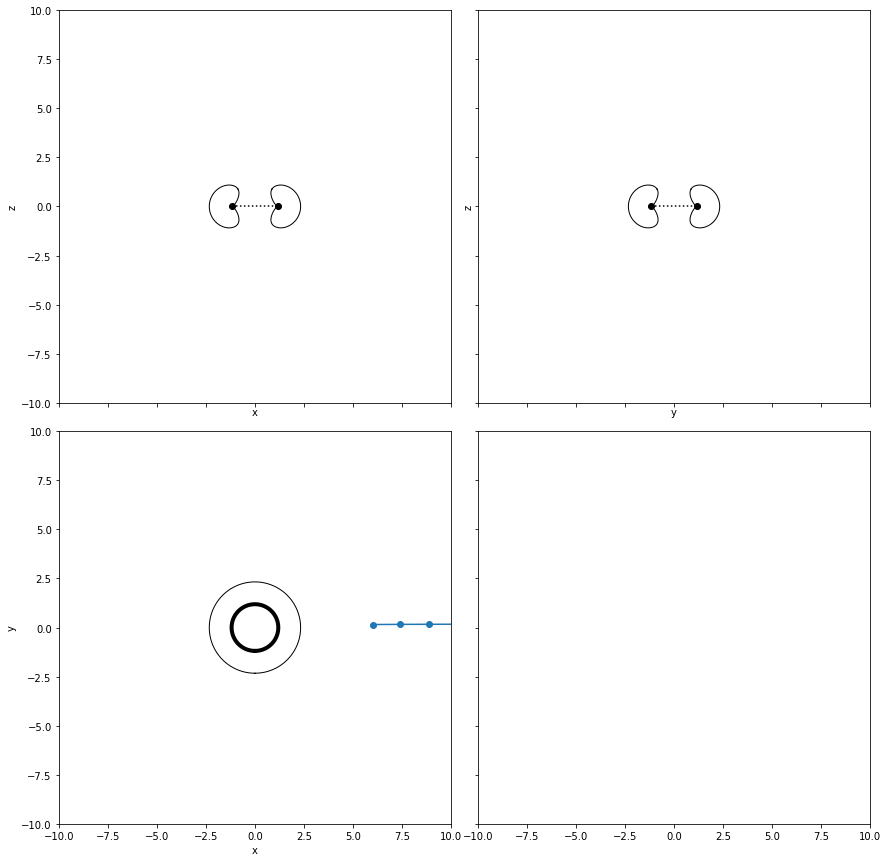

In [67]:
plot_single(ishadow_ex, jshadow_ex, 1850, -1, 10, a, f) # integration step 1850

When the photon enters the naked singularity, it spends a very long time (about 1300 out of 1900 integration steps) barely moving at all while k dot k stabilizes. Then, it makes a sharp turn/loop and escapes the naked singularity.

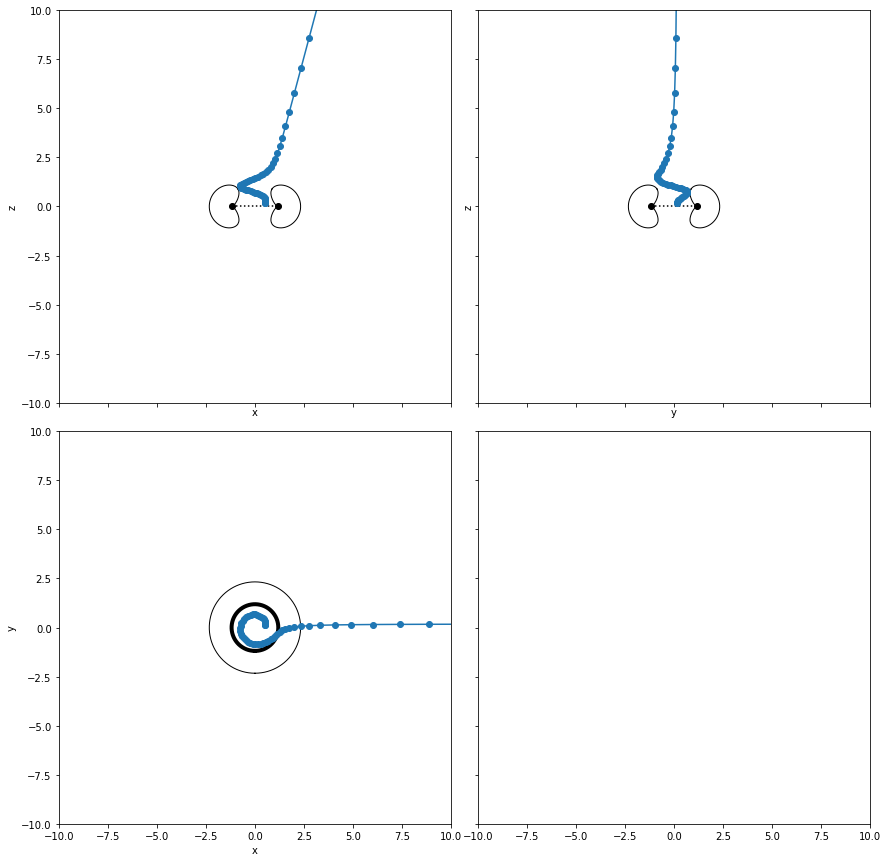

In [60]:
plot_single(ishadow_ex, jshadow_ex, 1800, -1, 10, a, f) 

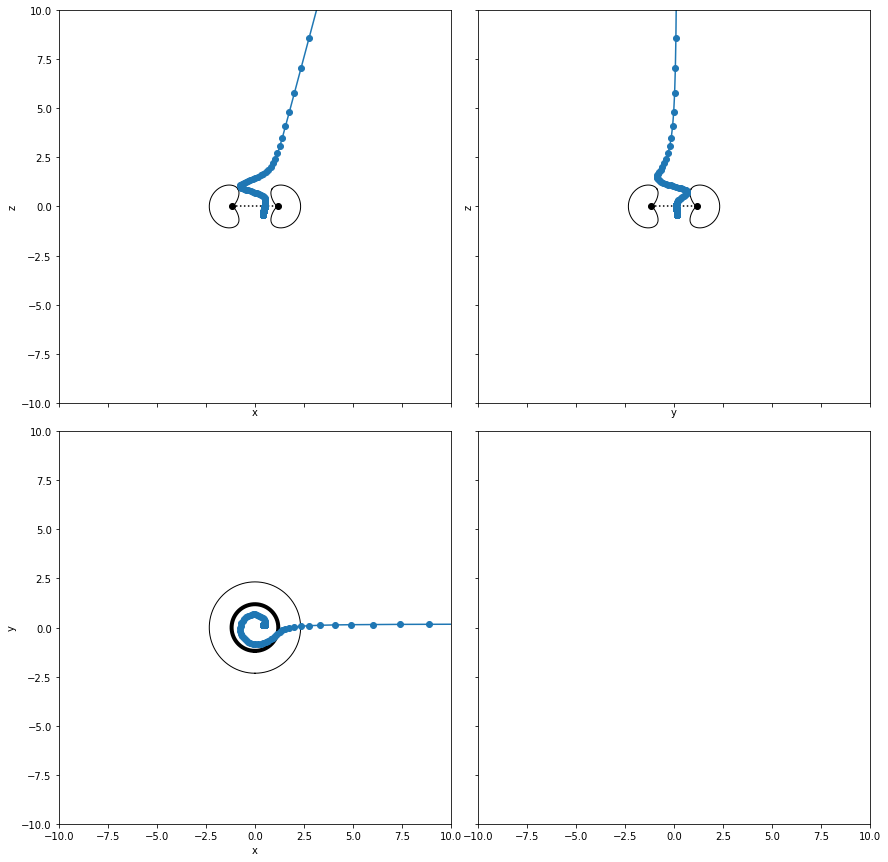

In [76]:
plot_single(ishadow_ex, jshadow_ex, 500, -1, 10, a, f) 

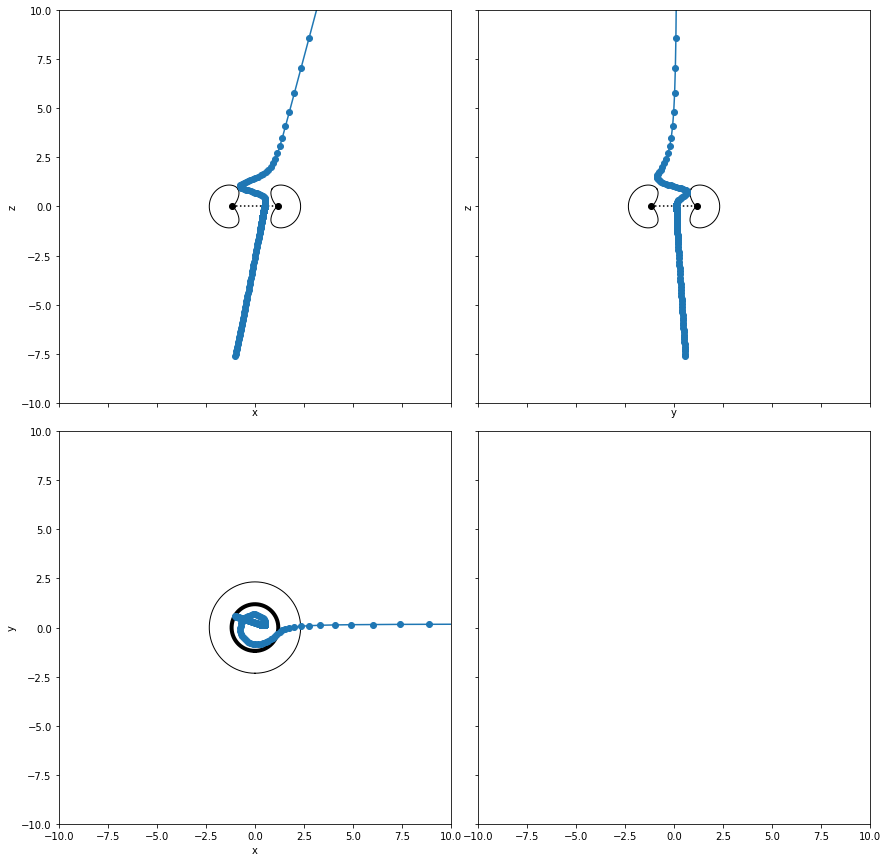

In [78]:
plot_single(ishadow_ex, jshadow_ex, 300, -1, 10, a, f) 

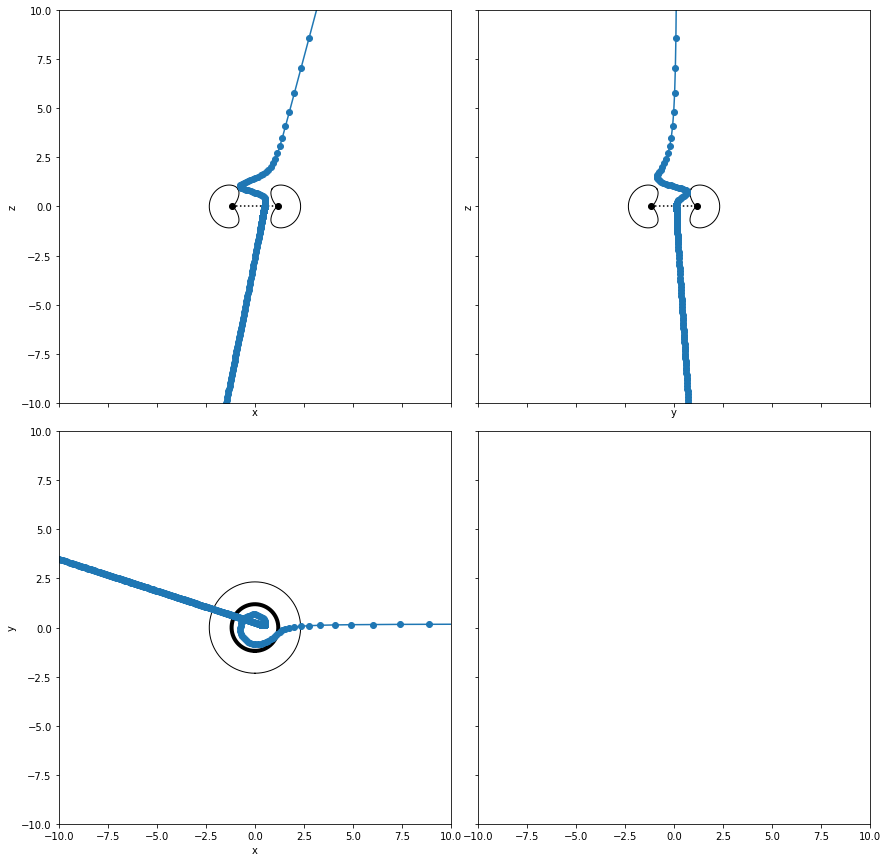

In [79]:
plot_single(ishadow_ex, jshadow_ex, 0, -1, 10, a, f) # full trajectory